This notebook is heavily inspired by https://towardsdatascience.com/build-a-bert-sci-kit-transformer-59d60ddd54a5

In [1]:
import transformers
from transformers import AutoTokenizer, AutoModel

In [2]:
transformers.logging.set_verbosity_info()

In [3]:
import numpy as np
from numpy.random import RandomState
import torch
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from typing import Callable, List, Optional, Tuple
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
import re
import matplotlib.pyplot as plt

## Set up

In [4]:
bert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at C:\Users\Matteo/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\Matteo/.cache\huggingface\transformers\45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f

In [ ]:
bert_tokenizer.additional_special_tokens

In [138]:
bert_tokenizer.tokenize("this is a very long word UNK")

['this', 'is', 'a', 'very', 'long', 'word', 'un', '##k']

In [141]:
bert_tokenizer.decode(bert_tokenizer.encode("[UNK]"))

'[CLS] [UNK] [SEP]'

In [124]:
bert_tokenizer.tokenize(["this", "is", "a", "very", "long", "word", "and", "this", "is", "an", "hashtag"], is_split_into_words=True)

['this',
 'is',
 'a',
 'very',
 'long',
 'word',
 'and',
 'this',
 'is',
 'an',
 'hash',
 '##tag']

In [121]:
test_encoding = bert_tokenizer.encode(["thi   s", "is", "a", "very", "long", "word", "and", "this", "is", "an", "hashtag"], is_split_into_words=True)
#test_encoding

In [125]:
bert_tokenizer.tokenize("tomorrow, i'll do that")

['tomorrow', ',', 'i', "'", 'll', 'do', 'that']

In [193]:
# Adapted from here: https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
contractions = { 
"ain't": "be not", # "am not / are not / is not / has not / have not",
"aren't": "be not", # "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would", # "he had / he would",
"he'd've": "he would have",
"he'll": "he will", # "he shall / he will",
"he's": "he is", # "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"howdy": "how do you",
"how'll": "how will",
"how's": "how", # "how has / how is / how does",
"i'd": "i would", # "I had / I would",
"i'd've": "i would have",
"i'll": "i will", # "I shall / I will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would", # "it had / it would",
"it'll": "it will", # "it shall / it will",
"it's": "it is", # "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mustn't": "must not",
"needn't": "need not",
"o'clock": "of the clock",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would", # "she had / she would",
"she'd've": "she would have",
"she'll": "she will", # "she shall / she will",
"she's": "she is", # "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"that's": "that is", # "that has / that is",
"there's": "there is", # "there has / there is",
"they'd": "they would", # "they had / they would",
"they'll": "they will", # "they shall / they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would", # "we had / we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what's": "what is", # "what has / what is",
"when've": "when have",
"where'd": "where did",
"where's": "where is", # "where has / where is",
"where've": "where have",
"who'll": "who will", # "who shall / who will",
"who's": "who is", # "who has / who is",
"who've": "who have",
"why's": "why is", # "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"would've": "would have",
"wouldn't": "would not",
"y'all": "you all",
"you'd": "you would", # "you had / you would",
"you'll": "you will", # "you shall / you will",
"you're": "you are",
"you've": "you have"
}

In [130]:
contractions["ain't"]

'be not'

In [208]:
def process_sentence(sentence_array, purge_methods):
    for method in purge_methods:
        sentence_array = method(sentence_array)
    return sentence_array

In [209]:
def remove_hashtag(before):
    if len(before) == 0:
        return ""
    
    if before[0] == "#":
        return before[1:]
    return before

In [210]:
def remove_contractions(before):
    if before in contractions:
        return contractions[before]
    return before

In [211]:
def remove_end_of_line(before):
    if len(before) == 0:
        return ""
    
    if before[-1] == '\n':
        return before[:-1]
    return before

In [221]:
def words_to_tags(before):
    if before == "<url>":
        return "[UNK]"
    elif before == "xox":
        return "kiss"
    elif before == "<user>":
        return "alice"
    return before

In [183]:
def to_method(lmt_wise_method):
    return np.vectorize(lmt_wise_method)

In [219]:
np.array(train_data[4565].split(" "))

array(['<user>', "don't", 'go', 'offline', 'xxx\n'], dtype='<U7')

In [223]:
process_sentence(np.array(train_data[4565].split(" ")), [to_method(remove_end_of_line), to_method(remove_hashtag), to_method(remove_contractions), to_method(words_to_tags)])

array(['alice', 'do not', 'go', 'offline', 'xxx'], dtype='<U7')

In [203]:
big_file = []
with open("twitter-datasets/train_pos_full_u.txt", "r") as f:
    for line in f.readlines():
        big_file.append(np.array(line.split(" ")))

In [212]:
big_file_proc = []
for sentence in big_file:
    big_file_proc.append(process_sentence(sentence, [to_method(remove_end_of_line), to_method(remove_hashtag), to_method(remove_contractions), to_method(tags_to_unk)]))

In [214]:
big_file_proc[:100]

[array(['!', '!', '!', '!', '!', '!', 'rt', '<user>', 'free', 'coldstones',
        'for', 'me', 'and', 'the', 'girls', 'i', 'could', 'get', 'use',
        'to', 'this', 'heaven'], dtype='<U10'),
 array(['!', '!', '!', '"', '<user>', 'gemini', 'are', 'entertaining', '.',
        'ever', 'have', 'one', 'in', 'bed', '?', 'try', 'it', '"'],
       dtype='<U12'),
 array(['!', '!', '!', '"', '<user>', "idontf'ckwitchu", 'cause', 'you',
        'think', 'i', 'want', 'your', 'man', 'but', 'really', 'he',
        'wants', 'me', '"'], dtype='<U15'),
 array(['!', '!', '!', '"', '<user>', 'np', 'fun', '-', 'we', 'are',
        'young', '...', 'i', 'that', 'song', '!', 'idc', 'what', 'anyone',
        'says', '"'], dtype='<U6'),
 array(['!', '!', '!', '"', '<user>', 'sagittarius', 'are', 'extremely',
        'turned', 'on', 'by', 'aggressive', 'lovers', '!', '"'],
       dtype='<U11'),
 array(['!', '!', '!', '"', '<user>', '<user>', 'hey', 'i', 'think', 'you',
        'should', 'go', 'blonde', 'ag

In [217]:
bert_tokenizer.tokenize(("xox  kiss").split(" "), is_split_into_words=True)

['x', '##ox', 'kiss']

In [173]:
bert_tokenizer.encode(["an", "thisisyou", "", "word"], is_split_into_words=True)

[101, 2019, 2023, 2483, 29337, 2773, 102]

In [175]:
bert_tokenizer.decode([101, 2019, 2023, 2483, 29337, 2773, 102])

'[CLS] an thisisyou word [SEP]'

In [172]:
bert_tokenizer.tokenize("thisisyou")

['this', '##is', '##you']

In [5]:
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at C:\Users\Matteo/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\Matteo/.cache\huggingface\transformers\9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e366

In [248]:
class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            bert_tokenizer,
            bert_model,
            max_length: int = 60,
            embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
            truncate = True,
    ):
        self.tokenizer = bert_tokenizer

        # TODO: Handle case with CPU only
        self.device = torch.device('cuda:0')

        self.model = bert_model.to(self.device)

        self.model.eval()
        self.max_length = max_length
        self.truncate = truncate
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0].cpu()[:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        # Tokenize the text with the provided tokenizer
        tokenized_text = self.tokenizer.encode_plus(
                          text,
                          add_special_tokens=True,
                          max_length=self.max_length,
                          truncation=self.truncate,
                          is_split_into_words=True,
                        )["input_ids"]

        # Create an attention mask telling BERT to use all words
        attention_mask = [1] * len(tokenized_text)

        # bert takes in a batch so we need to unsqueeze the rows
        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(text)

        # TODO: Handle case with CPU only
        tokenized_gpu = tokenized.to(self.device)
        attention_mask_gpu = attention_mask.to(self.device)

        with torch.no_grad():
            embeddings = self.model(tokenized_gpu, attention_mask_gpu)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        ## TODO: Debug (Should change it when finetuning)
        self.model.eval()
            
        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

In [7]:
rng = RandomState(124)

## Import data

In [8]:
neg_train = []
with open("twitter-datasets/train_neg_u.txt", "r") as f:
    for line in f.readlines():
        neg_train.append(line)

In [9]:
pos_train = []
with open("twitter-datasets/train_pos_u.txt", "r") as f:
    for line in f.readlines():
        pos_train.append(line)

In [10]:
len(neg_train), len(pos_train)

(91088, 90233)

## WARNING: I get rid of some negative samples to re-establish class equilibrium
Imbalanced classes are a pain

In [11]:
neg_train = neg_train[:len(pos_train)-len(neg_train)]

In [12]:
len(neg_train)

90233

#### Trim the dataset used for training
Right now, I only use 5K samples from each category to test the training
(17mins to train the model)

In [13]:
samples_num_by_cat = 40000

In [14]:
neg_train = neg_train[:samples_num_by_cat]
pos_train = pos_train[:samples_num_by_cat]

In [15]:
train_labels = np.concatenate([[0] * len(neg_train), [1] * len(pos_train)])

train_data = np.concatenate([neg_train, pos_train])

In [16]:
shuffling = np.arange(0, train_data.shape[0])
len(shuffling)

80000

In [17]:
rng.shuffle(shuffling)

In [18]:
train_labels = train_labels[shuffling]
train_data = train_data[shuffling]

In [224]:
train_tokenized = []
for sentence in train_data:
    train_tokenized.append(process_sentence(np.array(sentence.split(" ")), [to_method(remove_end_of_line), to_method(remove_hashtag), to_method(remove_contractions), to_method(words_to_tags)]))

In [240]:
train_data = np.array(train_tokenized)

## Run the model

#### Take care of strange tokens

In [232]:
strange = set()
for el in train_data:
    for spec in re.findall("(<[^(<|\s|3]*?>)", el):
        if spec not in strange:
            strange.add(spec)

TypeError: cannot use a string pattern on a bytes-like object

In [233]:
strange

set()

In [234]:
# Skip for now
# purified_train = []
# for tp in train_data:
#   for st in strange:
#     purified_train.append(tp.replace(st, "[UNK]"))

In [235]:
train_df = pd.DataFrame(zip(train_labels, train_data), columns=["emotion", "tweet"])

In [236]:
train_df

,emotion,tweet
0,1,"[alice, hey, baby, ,, you, wanna, pick, me, up..."
1,0,"[alive, in, south, africa, (, audio, cd, get, ..."
2,0,"[alice, i, actually, am, he, said, lutons, too..."
3,1,"[alice, alice, these, glasses, are, very, nice..."
4,0,"[alice, please, folback, this, fanbase]"
...,...,...
79995,1,"[alice, alice, of, course, !, i, follow, you, ..."
79996,0,"[alice, -, he, wont, eat, or, drink, and, when..."
79997,1,"[alice, no, prob, ., good, luck, !, you are, s..."
79998,1,"[alice, sorry, ,, earth, day, is, the, 22nd, ...."


In [237]:
split = rng.choice(
    ["train", "val", "test"],
    size=len(train_data),
    p=[.8, .1, .1]
)
split

array(['val', 'train', 'train', ..., 'test', 'train', 'train'],
      dtype='<U5')

In [242]:
bert_x_data = train_data[split == "train"]
bert_labels = train_labels[split == "train"]

In [243]:
torch.cuda.is_available()

True

In [244]:
torch.cuda.get_device_properties('cuda:0')

_CudaDeviceProperties(name='GeForce GTX 1650', major=7, minor=5, total_memory=4096MB, multi_processor_count=16)

In [249]:
bert_transformer = BertTransformer(bert_tokenizer, bert_model)

In [250]:
random_forest = RandomForestClassifier(n_estimators=50, random_state=0)

In [251]:
classifier = svm.LinearSVC(C=1.0, class_weight="balanced", max_iter=100000)

In [252]:
model = Pipeline(
    [
        ("vectorizer", bert_transformer),
        ("classifier", classifier),
    ], verbose=True 
)

In [253]:
model.fit(bert_x_data, bert_labels)

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=10.6min
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 6.7min


Pipeline(memory=None,
         steps=[('vectorizer',
                 BertTransformer(bert_model=None, bert_tokenizer=None,
                                 embedding_func=<function BertTransformer.__init__.<locals>.<lambda> at 0x000001DC532C65E8>,
                                 max_length=60, truncate=True)),
                ('classifier',
                 LinearSVC(C=1.0, class_weight='balanced', dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=100000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=True)

In [255]:
model.score(train_data[split == "train"], train_labels[split == "train"])

0.7364615865084322

In [256]:
model.score(train_data[split == "val"], train_labels[split == "val"])

0.7198399799974997

In [134]:
test_embeddings = bert_transformer.transform(train_data[split == "test"])

In [257]:
train_embeddings = bert_transformer.transform(bert_x_data[:40000])

In [258]:
classifier.fit(train_embeddings, train_labels[split == "train"][:40000])

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=100000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [261]:
classifier.score(train_embeddings, train_labels[split == "train"][:40000])

0.739275

In [138]:
classifier.score(test_embeddings, train_labels[split == "test"])

0.8176395939086294

In [140]:
from sklearn.linear_model import LogisticRegression

In [146]:
log_regr = LogisticRegression(solver="lbfgs", max_iter=100000)

In [147]:
log_regr.fit(train_embeddings, train_labels[split == "train"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [148]:
log_regr.score(test_embeddings, train_labels[split == "test"])

0.8185279187817259

In [151]:
test_embeddings.shape

torch.Size([7880, 768])

In [154]:
log_regr.predict(test_embeddings[0:10,:])

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 0])

In [149]:
from sklearn.metrics import confusion_matrix

In [201]:
conf_mat = confusion_matrix(train_labels[split == "test"], log_regr.predict(test_embeddings), labels=[0,1])

In [202]:
train_labels[split == "test"][:3], log_regr.predict(test_embeddings[:3,:])

(array([1, 0, 1]), array([1, 1, 1]))

In [203]:
conf_mat

array([[3111,  854],
       [ 576, 3339]], dtype=int64)

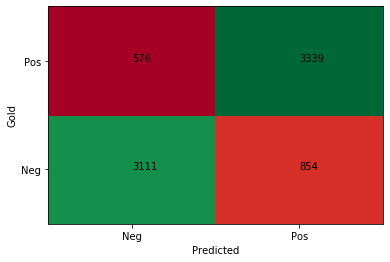

In [205]:
plt.pcolormesh(conf_mat, cmap="RdYlGn")
plt.xticks([0.5, 1.5], labels=["Neg", "Pos"])
plt.yticks([0.5, 1.5], labels=["Neg", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Gold")
for i in range(2):
    for j in range(2):
        plt.text(i+.5, j+.5, str(conf_mat[j, i]))

In [100]:
random_forest.fit(train_embeddings, train_labels[split == "train"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [101]:
random_forest.score(train_embeddings, train_labels[split == "train"])

1.0

In [102]:
random_forest.score(test_embeddings, train_labels[split == "test"])

0.782608695652174

In [206]:
from sklearn.neural_network import MLPClassifier

In [218]:
ml_perceptron = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 2), max_iter=100000, random_state=1)

In [219]:
ml_perceptron.fit(train_embeddings, train_labels[split == "train"])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=100000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [220]:
ml_perceptron.score(train_embeddings, train_labels[split == "train"])

0.8444683739875463

In [223]:
ml_perceptron.score(test_embeddings, train_labels[split == "test"])

0.8237309644670051

In [256]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [302]:
pac = PassiveAggressiveClassifier(loss='squared_hinge', max_iter=100000)

In [319]:
pac.fit(train_embeddings, train_labels[split == "train"])

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='squared_hinge', max_iter=100000,
                            n_iter_no_change=5, n_jobs=None, random_state=None,
                            shuffle=True, tol=0.001, validation_fraction=0.1,
                            verbose=0, warm_start=False)

In [320]:
pac.score(test_embeddings, train_labels[split == "test"])

0.8110406091370559

In [301]:
import xgboost as xgb

In [298]:
param_dist = {'objective':'binary:hinge', 'n_estimators':50 }

clf = xgb.XGBModel(**param_dist)

In [253]:
clf.fit(train_embeddings.numpy(), train_labels[split == "train"], eval_set=[
    (train_embeddings.numpy(), train_labels[split == "train"]),
    (test_embeddings.numpy(), train_labels[split == "test"])
],
        eval_metric='mphe',
        verbose=True)

[0]	validation_0-mphe:0.20698	validation_1-mphe:0.20842
[1]	validation_0-mphe:0.15656	validation_1-mphe:0.15890
[2]	validation_0-mphe:0.14245	validation_1-mphe:0.14571
[3]	validation_0-mphe:0.12972	validation_1-mphe:0.13289
[4]	validation_0-mphe:0.12189	validation_1-mphe:0.12642
[5]	validation_0-mphe:0.11554	validation_1-mphe:0.11948
[6]	validation_0-mphe:0.11018	validation_1-mphe:0.11433
[7]	validation_0-mphe:0.10552	validation_1-mphe:0.11112
[8]	validation_0-mphe:0.10198	validation_1-mphe:0.10734
[9]	validation_0-mphe:0.09835	validation_1-mphe:0.10476
[10]	validation_0-mphe:0.09514	validation_1-mphe:0.10140
[11]	validation_0-mphe:0.09207	validation_1-mphe:0.10019
[12]	validation_0-mphe:0.08943	validation_1-mphe:0.09809
[13]	validation_0-mphe:0.08721	validation_1-mphe:0.09756
[14]	validation_0-mphe:0.08511	validation_1-mphe:0.09682
[15]	validation_0-mphe:0.08266	validation_1-mphe:0.09530
[16]	validation_0-mphe:0.08076	validation_1-mphe:0.09367
[17]	validation_0-mphe:0.07887	validation

XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
         importance_type='gain', interaction_constraints='',
         learning_rate=0.300000012, max_delta_step=0, max_depth=6,
         min_child_weight=1, missing=nan, monotone_constraints='()',
         n_estimators=50, n_jobs=0, num_parallel_tree=1,
         objective='binary:hinge', random_state=0, reg_alpha=0, reg_lambda=1,
         scale_pos_weight=None, subsample=1, tree_method='exact',
         validate_parameters=1, verbosity=None)

In [254]:
(clf.predict(test_embeddings.numpy()) == train_labels[split == "test"]).mean()

0.7977157360406092

## biLSTM

Inspired by this: https://discuss.pytorch.org/t/lstm-to-bi-lstm/12967/2

In [27]:
from torch import nn, optim

In [28]:
import torch.nn.functional as F

In [69]:
# Binary classification with bidirectional LSTM
class biLSTM(nn.Module):
    
    def __init__(self, embeddings_size, hidden_size, batch_size, gpu_device):
        super(biLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.gpu_device = gpu_device
        
        self.lstm = nn.LSTM(embeddings_size, hidden_size, bidirectional=True, batch_first=True).to(gpu_device)
        
        self.out_layer = nn.Linear(hidden_size * 2, 1).to(gpu_device)
        
        # Classification
        self.sigmoid = nn.Sigmoid()
        
        # Hidden state for LSTM
        self.hidden_state = self.initialize_hidden()
        
    def initialize_hidden(self):
        return (torch.autograd.Variable(torch.randn(2, self.batch_size, self.hidden_size)).to(self.gpu_device),   
                torch.autograd.Variable(torch.randn(2, self.batch_size, self.hidden_size)).to(self.gpu_device))
    
    def detach_hidden(self):
        self.hidden_state = (self.hidden_state[0].detach(), self.hidden_state[1].detach())
    
    def forward(self, embeddings):
        input_data = embeddings
        
#         print("input_data:", input_data.is_cuda)
#         print("hidden_state:", self.hidden_state[0].is_cuda, self.hidden_state[1].is_cuda)
        
        lstm_output, self.hidden_state = self.lstm(input_data, self.hidden_state)
#         print(lstm_output.shape)
        
        # Class decision
        lstm_output = lstm_output[:,-1,:]
        tags_probs = self.out_layer(lstm_output)
        decision = self.sigmoid(tags_probs)
        decision = decision.squeeze()
        
        return decision

In [70]:
gpu = torch.device('cuda:0')

In [95]:
after_bert = biLSTM(768, 50, batch_size=100, gpu_device=gpu)

In [96]:
def equalize_embeddings(max_length=512):
    def _equalize(x):
        content = x[0]
        long_embds = torch.zeros([content.size(0), max_length, content.size(2)])
        long_embds[:, (max_length - content.size(1)):, :] = content
        return long_embds
    return _equalize

In [97]:
sophisticated_bert = BertTransformer(bert_tokenizer, bert_model, embedding_func=equalize_embeddings(256), max_length=256, truncate=True)

In [98]:
sophisticated_embs = sophisticated_bert.transform(bert_x_data[:100])
sophisticated_embs.shape

torch.Size([100, 1, 256, 768])

In [99]:
from torch.utils.data import TensorDataset, DataLoader

In [100]:
bert_x_data.shape

(64063,)

In [40]:
# train_dataset = TensorDataset(sophisticated_embs.squeeze(), torch.from_numpy(bert_labels[:30000]))

In [41]:
# train_loader = DataLoader(train_dataset, batch_size=5)

In [45]:
small_testset = sophisticated_embs[:5,...].squeeze().to(gpu)
after_bert(small_testset)

tensor([0.4212, 0.4394, 0.4370, 0.4397, 0.4276], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

### Training

In [101]:
def get_tweet_batches(data, labels, batch_size=5):
    for i in range(data.shape[0] // batch_size):
        yield (data[i*batch_size:(i+1)*batch_size], labels[i*batch_size:(i+1)*batch_size])

In [88]:
epochs = 5
lr=0.05
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(after_bert.parameters(), lr=lr)

logs_step = 100
training_ctr = 0

In [89]:
# list(after_bert.parameters())

In [102]:
torch.cuda.empty_cache()

In [103]:
torch.autograd.set_detect_anomaly(True)

In [104]:
after_bert.train()
for epch in range(epochs):
    for inputs, labels in get_tweet_batches(train_data[:20000], train_labels[:20000], batch_size=100):
        training_ctr += 1
        
        embeddings = sophisticated_bert.transform(inputs)
        embeddings = embeddings.squeeze()
        labels = torch.from_numpy(labels)
        embeddings, labels = embeddings.to(gpu), labels.to(gpu)
        
        after_bert.detach_hidden()
        after_bert.zero_grad()
        output = after_bert(embeddings)
        loss = criterion(output, labels.float())
        loss.backward()
        #nn.utils.clip_grad_norm_(after_bert.parameters(), 5)
        optimizer.step()
        
        if training_ctr % logs_step == 0:
            print("Epoch: %d \t Loss: %.3f" % (epch, loss.item()))
        

Epoch: 0 	 Loss: 0.699
Epoch: 0 	 Loss: 0.691
Epoch: 1 	 Loss: 0.699
Epoch: 1 	 Loss: 0.691
Epoch: 2 	 Loss: 0.699
Epoch: 2 	 Loss: 0.691
Epoch: 3 	 Loss: 0.699
Epoch: 3 	 Loss: 0.691
Epoch: 4 	 Loss: 0.699
Epoch: 4 	 Loss: 0.691


In [94]:
criterion(after_bert(sophisticated_embs.squeeze()[1000:1005,...].to(gpu)).cpu(), torch.from_numpy(bert_labels[1000:1005]).float())

RuntimeError: Expected hidden[0] size (2, 0, 50), got (2, 30, 50)

In [677]:
criterion(torch.tensor([.5, .5, 0, .5, 0]).float(), torch.from_numpy(bert_labels[5:10]).float())

tensor(0.4159)

In [670]:
bert_labels[5:10]

array([0, 1, 0, 0, 0])

## Predict

In [335]:
def prepare_submission(emb_model, classifier_model):
    unk_ids = []
    unk_data = []
    with open("twitter-datasets/twitter-datasets/test_data.txt", "r") as f:
        for line in f.readlines():
            comma_pos = line.find(",")
            unk_ids.append(line[:comma_pos])
            unk_data.append(line[comma_pos+1:])
            
    # Sanity check
    assert len(unk_data) == 10000
    
    print("Embedding model: " + str(type(emb_model)))
    print("Calculating embeddings...")
    unk_embs = emb_model.transform(unk_data)
    
    print("Classifier model: " + str(type(classifier_model)))
    print("Predicting labels...")
    pred_labels = classifier_model.predict(unk_embs)
    
    return pred_labels

In [336]:
prepare_submission(bert_transformer, ml_perceptron)

Embedding model: <class '__main__.BertTransformer'>
Calculating embeddings...
Classifier model: <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
Predicting labels...


array([0, 0, 0, ..., 0, 1, 0])

"men's montana boot in brown / ap green color : tan , size : 9 , width : m ( medium rm288233 - tan - 9 - m color : tan , size ... <url>\n"

In [ ]:
unk_embeddings = 

In [339]:
bert_tokenizer.tokenize("the tunguska mystery ( astronomers ' universe ) ( hardcover the purpose of the book is a dual one : to detail the n ... <url>")

['the',
 'tung',
 '##us',
 '##ka',
 'mystery',
 '(',
 'astronomers',
 "'",
 'universe',
 ')',
 '(',
 'hardcover',
 'the',
 'purpose',
 'of',
 'the',
 'book',
 'is',
 'a',
 'dual',
 'one',
 ':',
 'to',
 'detail',
 'the',
 'n',
 '.',
 '.',
 '.',
 '<',
 'ur',
 '##l',
 '>']